### Universidad de Granada | ETSIIT | Escuela Internacional de Posgrado
---
# **Proyecto Final**: Naïve Bayes
---
**Asignatura:** Minería de Datos: Preprocesamiento y Clasificación

**Autor:** Lugli, Valentino Glauco · YB0819879

# Librerías y Datos

In [399]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy import stats
from tabulate import tabulate

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, KBinsDiscretizer
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_classif
from sklearn.cluster import DBSCAN



from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.over_sampling import SMOTE

In [400]:
df_credit = pd.read_csv("../data_preprocess/train_preprocess.csv").drop(columns=["ID"])

df_credit_x = df_credit.drop(columns=["RATE"])
df_credit_y = df_credit["RATE"]

df_test = pd.read_csv("../data_preprocess/test_preprocess.csv")
df_test_values = df_test.drop(columns=["ID"])
df_test_IDs = df_test["ID"]

In [408]:
X_train, X_test, y_train, y_test = train_test_split(df_credit_x, 
                                                    df_credit_y, stratify=df_credit_y, 
                                                    test_size=0.2, 
                                                    random_state=16)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = pd.DataFrame(scaler.transform(X_train), columns=df_credit_x.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=df_credit_x.columns)

# minmax = MinMaxScaler()
# minmax.fit(X_train)

# X_train = minmax.transform(X_train)
# X_test = minmax.transform(X_test)

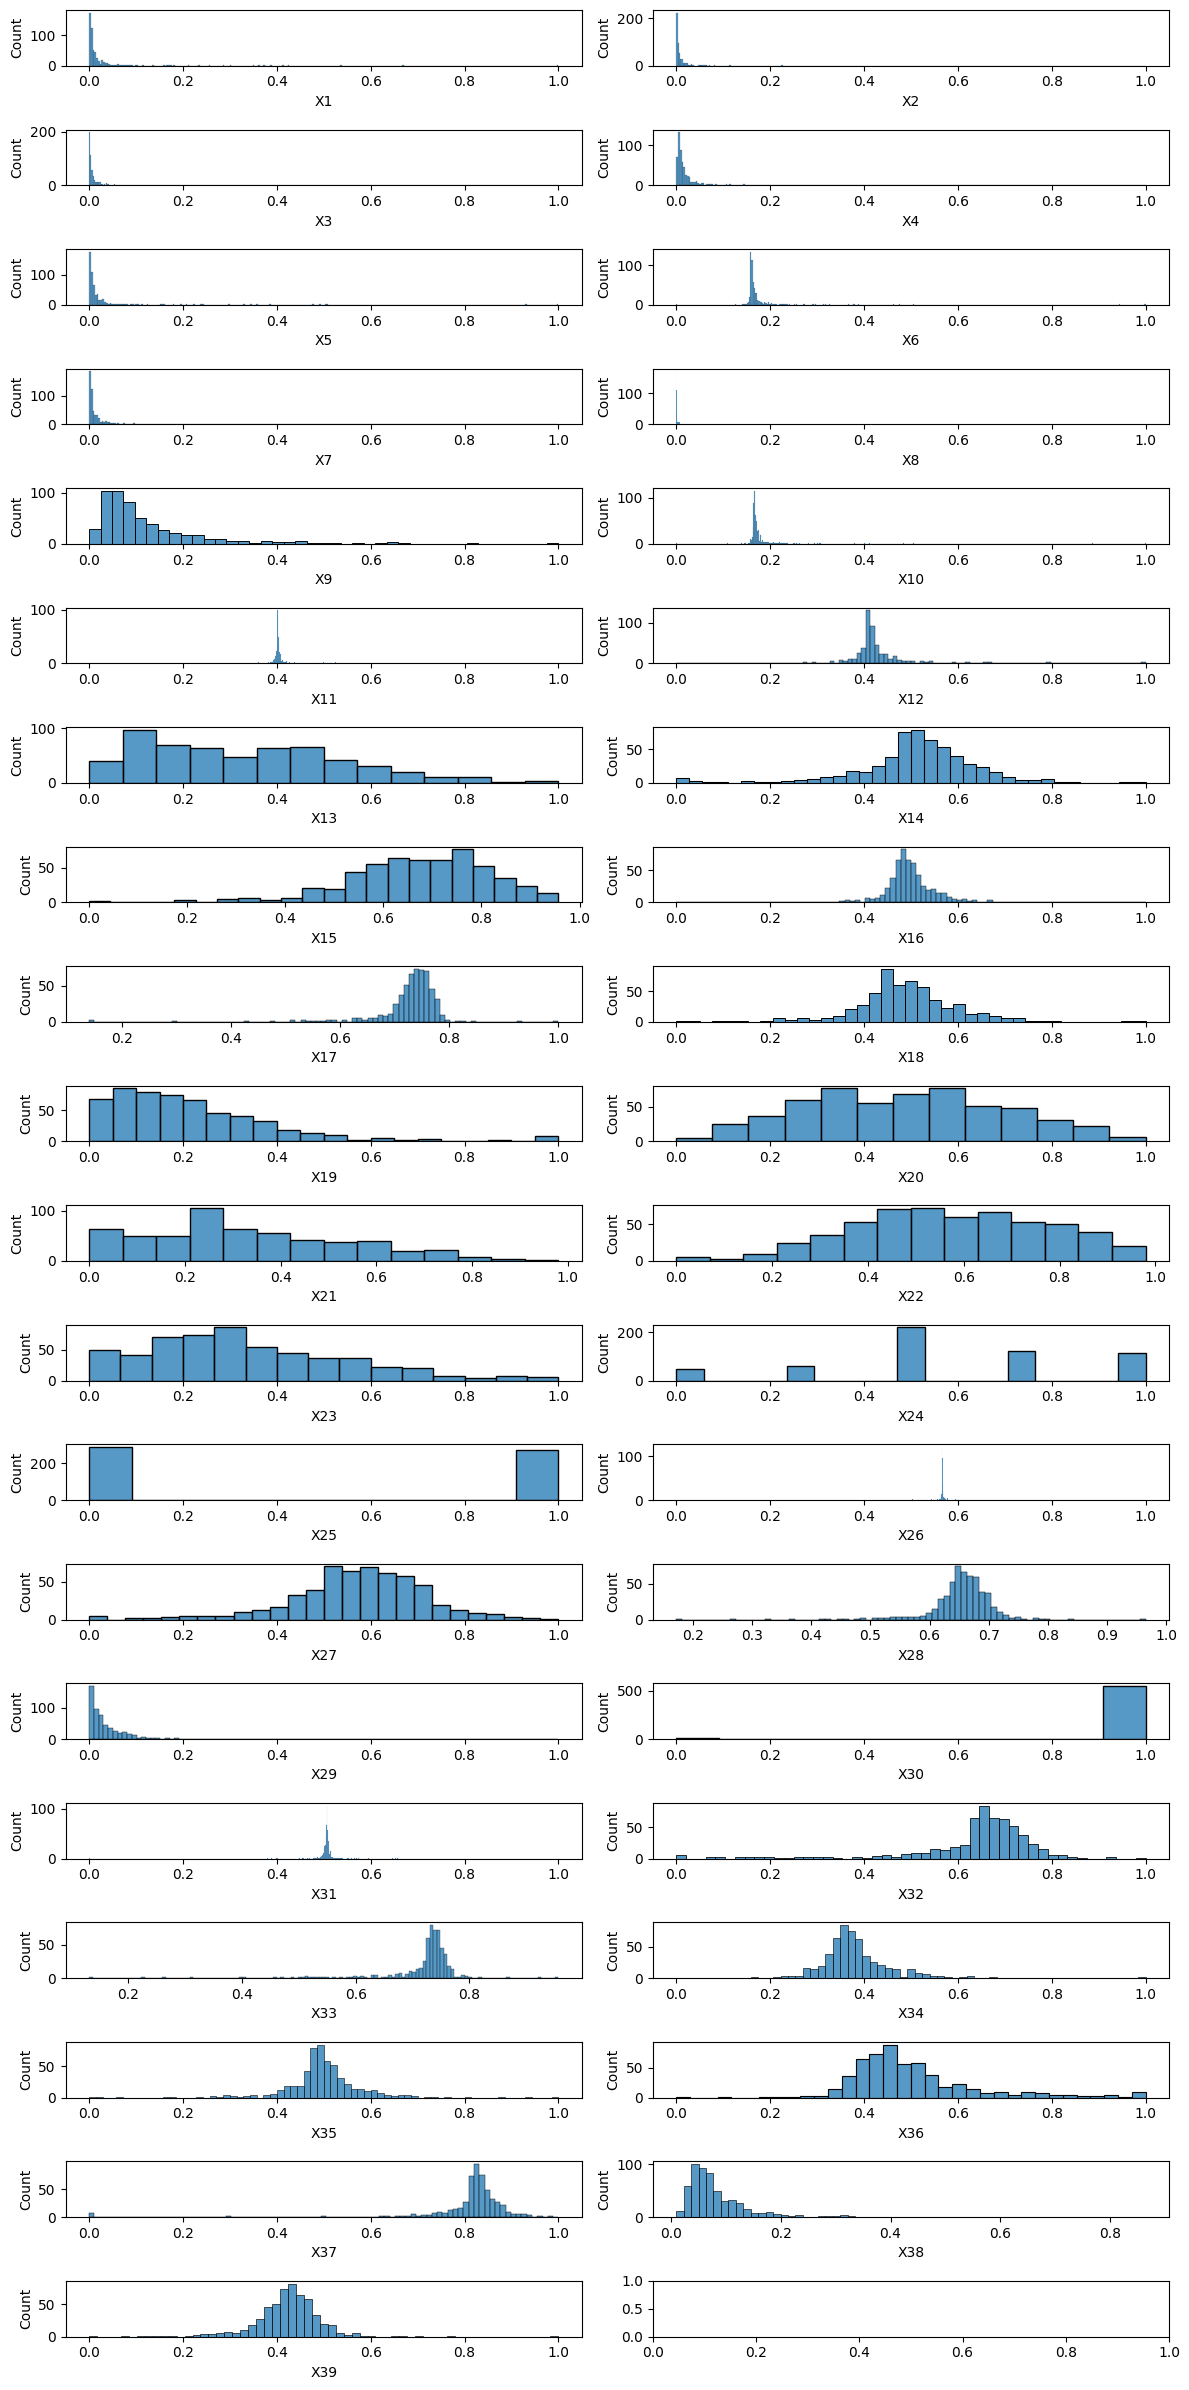

In [402]:
fig, axes = plt.subplots(nrows=20, ncols=2, figsize=(12, 24))

# Flatten the axes array to iterate through each subplot
axes = axes.flatten()

# Loop through each column and create a violin plot
for i, column in enumerate(df_credit_x.columns):
    sns.histplot(x=df_credit_x[column], ax=axes[i])

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

TypeError: Data source must be a DataFrame or Mapping, not <class 'pandas.core.series.Series'>.

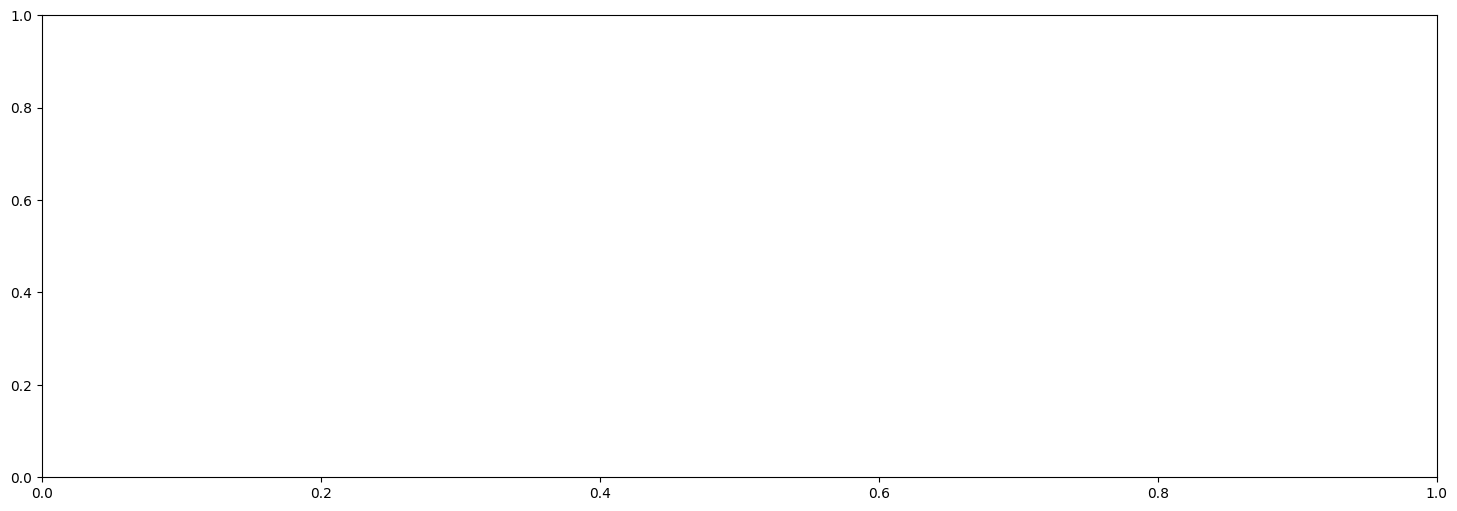

In [403]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(18, 6))

sns.countplot(df_credit_y, x="RATE", ax=axes)
axes.bar_label(axes.containers[0])

plt.show()

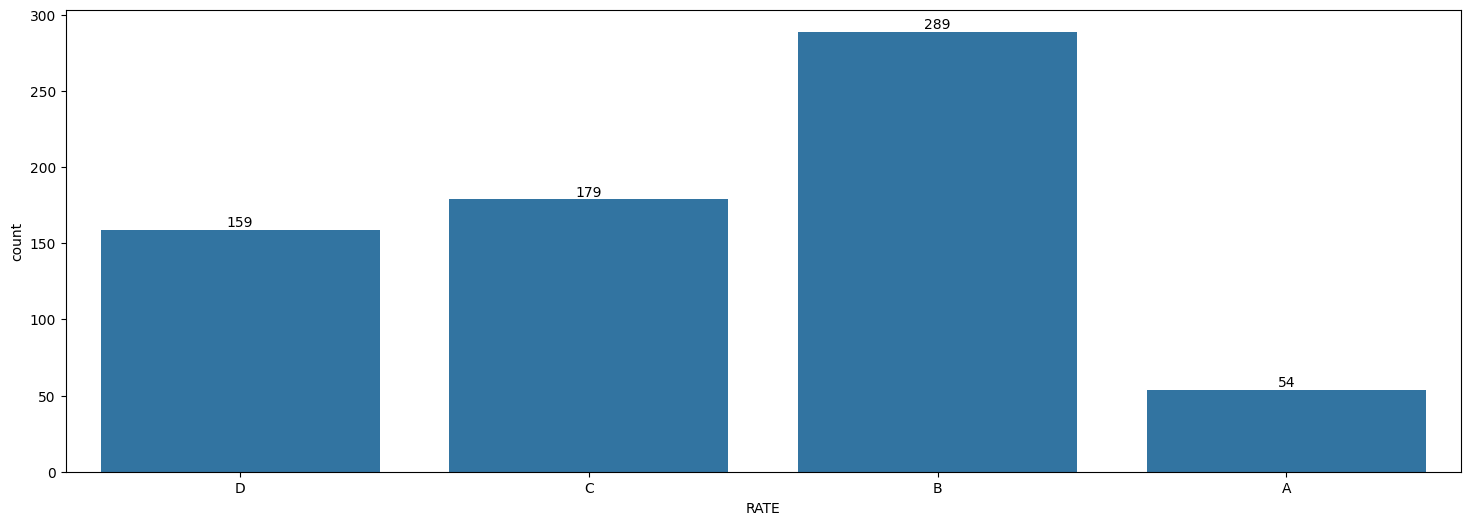

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(18, 6))

temporal_df = pd.DataFrame(y_train, columns=["RATE"])
sns.countplot(temporal_df, x="RATE", ax=axes)
axes.bar_label(axes.containers[0])

plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=20, ncols=2, figsize=(12, 24))

# Flatten the axes array to iterate through each subplot
axes = axes.flatten()
temporal_df = pd.DataFrame(X_train)
# Loop through each column and create a violin plot
for i, column in enumerate(temporal_df.columns):
    sns.histplot(x=temporal_df[column], ax=axes[i])

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

KeyboardInterrupt: 

KeyboardInterrupt: 

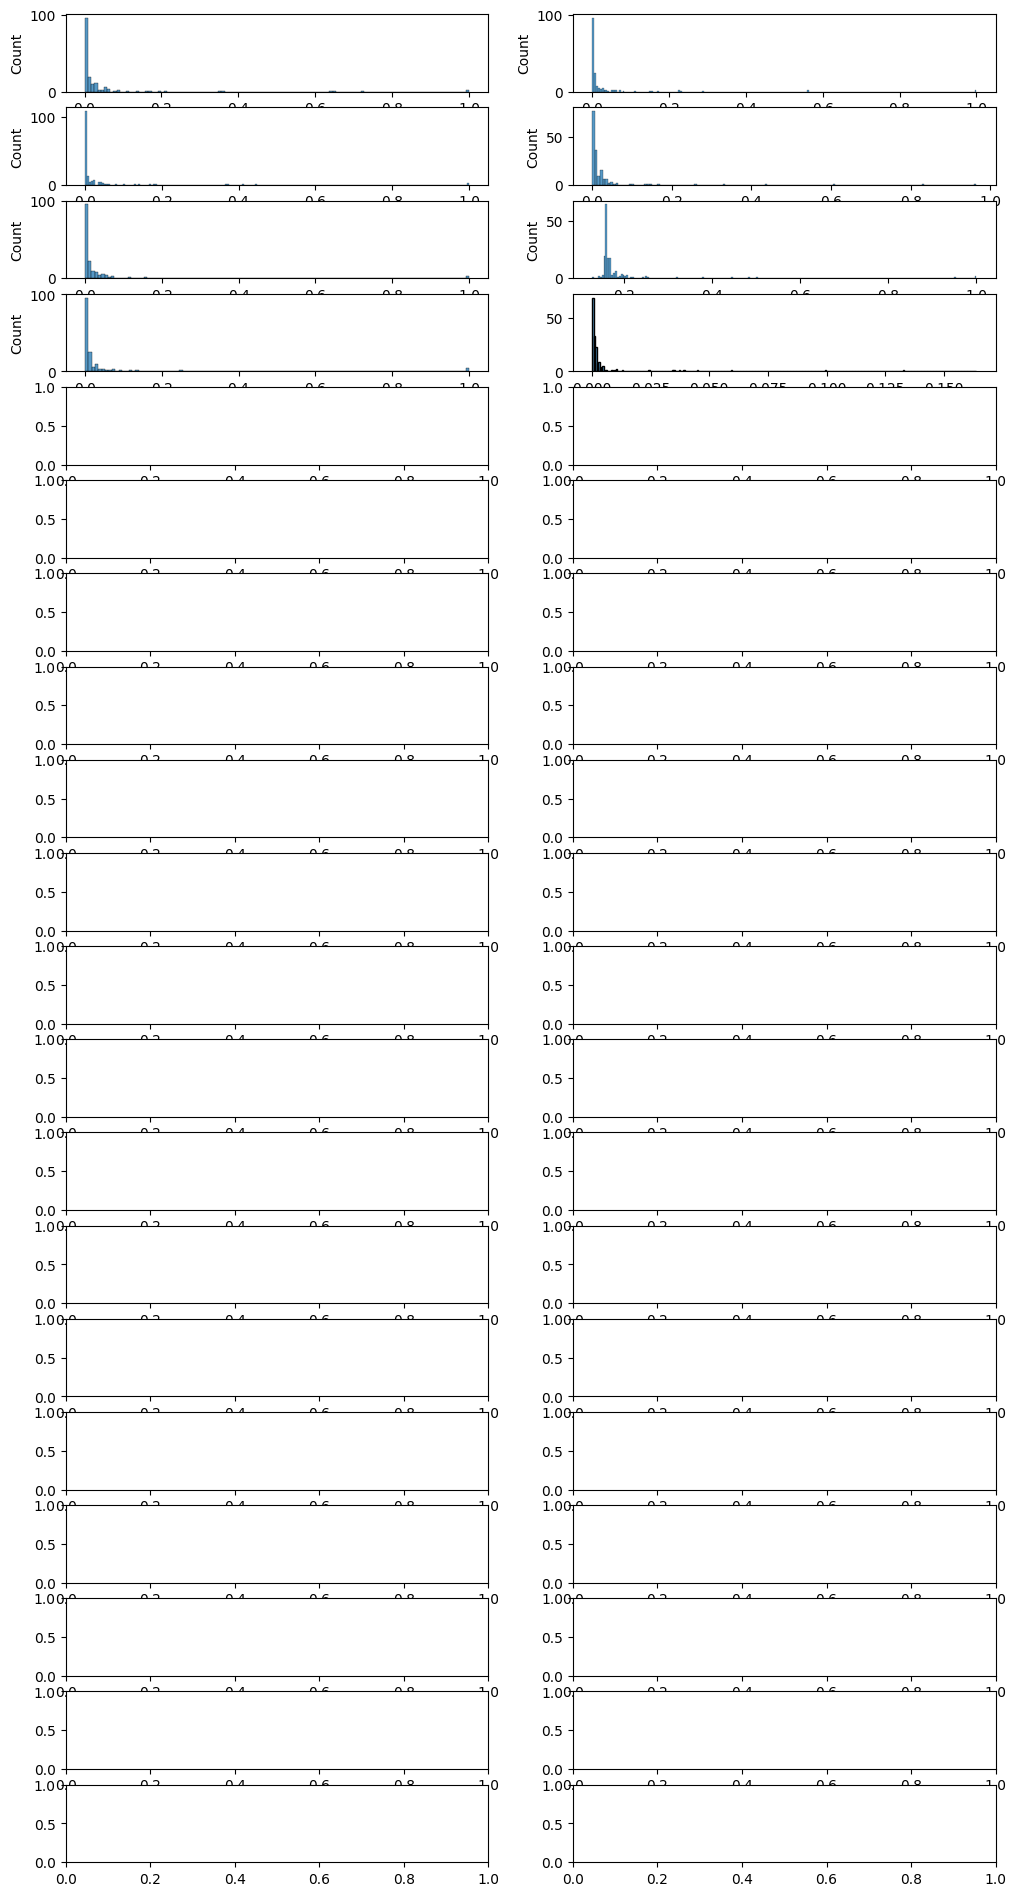

In [ ]:
fig, axes = plt.subplots(nrows=20, ncols=2, figsize=(12, 24))

# Flatten the axes array to iterate through each subplot
axes = axes.flatten()
temporal_df = pd.DataFrame(X_test)
# Loop through each column and create a violin plot
for i, column in enumerate(temporal_df.columns):
    sns.histplot(x=temporal_df[column], ax=axes[i])

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

# Experimentos

## Funciones

In [17]:
def naive_bayes_fits(results, x_train, y_train, x_test, y_test, show_cf = True):
    best_acc = -1
    body   = []
    for model in results:

        y_pred_train = results[model]["model"].fit(x_train, y_train).predict(x_train)
        y_pred_test  = results[model]["model"].predict(x_test)
        results[model]["train"] = classification_report(y_train, y_pred_train, output_dict=True, zero_division=0)
        results[model]["test"]  = classification_report(y_test, y_pred_test, output_dict=True, zero_division=0)
        results[model]["test_pred"]  = y_pred_test
        results[model]["train_pred"]  = y_pred_train
        act_acc = results[model]["test"]["accuracy"]

        body.append([model, results[model]["train"]["accuracy"] * 100, results[model]["test"]["accuracy"] * 100])
        if act_acc > best_acc:
            best_acc = act_acc

    # print(tabulate(body, headers=header, floatfmt=".4f"))
    naive_bayes_stats(results, y_test, show_cf=show_cf)

    return results


def naive_bayes_stats(results, y_test, show_cf = True):
    
    header = ["Variant", "F1 Score", "Train Acc", "Test Acc"]
    body = []
    matrices = []

    for m in results:
        body.append([m, results[m]["test"]["macro avg"]["f1-score"], results[m]["train"]["accuracy"] * 100, results[m]["test"]["accuracy"] * 100])
        matrices.append(confusion_matrix(y_test, results[m]["test_pred"]))
    print(tabulate(body, headers=header, floatfmt=".4f"))

    if(show_cf):
        fig, axes = plt.subplots(nrows=1, ncols=len(matrices), figsize=(18, 4))

        tick_labels = ["A", "B", "C", "D"]

        if(len(matrices) > 1):
            axes = axes.flatten()
        else:
            curr_ax = axes

        for i, model in enumerate(results):
            if(len(matrices) > 1):
                curr_ax = axes[i]

            sns.heatmap(matrices[i], ax=curr_ax, annot=True, xticklabels=tick_labels, yticklabels=tick_labels)
            curr_ax.title.set_text(model)
            curr_ax.set_xlabel("Predicted") 
            curr_ax.set_ylabel("Real") 

        plt.tight_layout()
        plt.show()


def get_kaggle_pred(model, data, id, fname="kaggle_out", path="./"):
    model_pred = model.predict(data)
    kaggle_dict = {"ID" : id, "RATE" : model_pred}
    pd.DataFrame(data=kaggle_dict).to_csv(os.path.join(path, fname, ".csv"), index=False)

## Datos Originales

In [404]:
results = {
    "gaussian" : {"model" : GaussianNB()},
    # "multinom" : {"model" : MultinomialNB(force_alpha=True)},
    # "complement" : {"model" : ComplementNB(force_alpha=True)},
    # "bernoulli" : {"model" : BernoulliNB(force_alpha=True)},
    # "categorical_1" : {"model" : CategoricalNB(force_alpha=True)},
    # "categorical_2" : {"model" : CategoricalNB(force_alpha=True, fit_prior=False)},
    # "categorical_4" : {"model" : CategoricalNB(force_alpha=True, alpha=0.75)}
}

Variant      F1 Score    Train Acc    Test Acc
---------  ----------  -----------  ----------
gaussian       0.1256      17.8571     11.6071


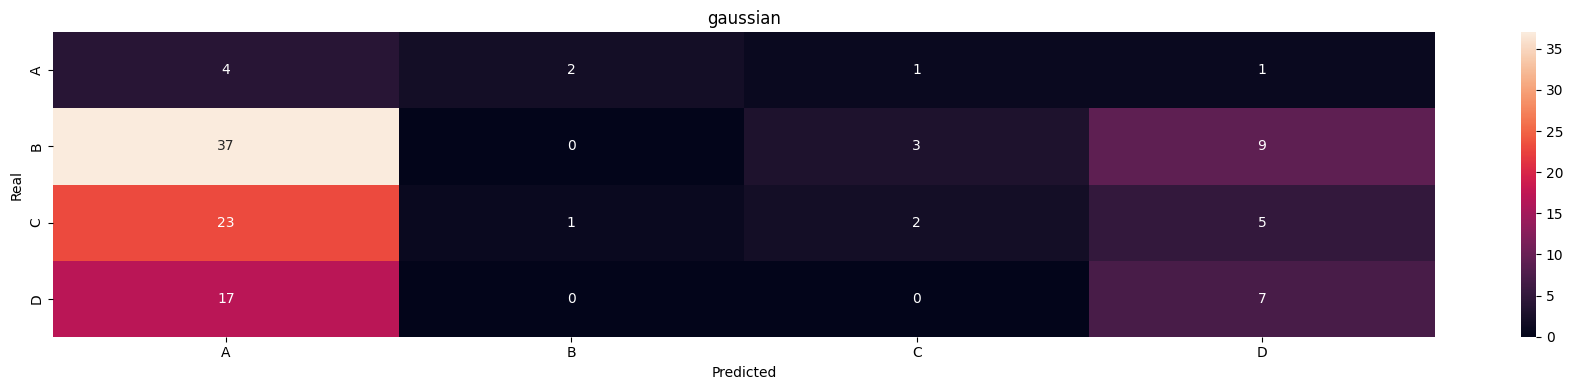

In [411]:
res_og = naive_bayes_fits(results, X_train, y_train, X_test, y_test)

## Seleccionando Características

In [396]:
fs = SelectPercentile(score_func=f_classif, percentile=25)
X_selected = fs.fit_transform(df_train.drop(columns=["RATE"]), df_train["RATE"])
print(X_selected.shape)

X_train, X_test, y_train, y_test = train_test_split(X_selected, 
                                                    df_train["RATE"], stratify=df_train["RATE"], 
                                                    test_size=0.2, 
                                                    random_state=16)
res = naive_bayes_fits(X_train, y_train, X_test, y_test)

NameError: name 'df_train' is not defined

### Quitando Variables Colineales

In [90]:
def get_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model 
        to generalize and improves the interpretability of the model.

    Inputs: 
        x: features dataframe
        threshold: features with correlations greater than this value are removed

    Output: 
        dataframe that contains only the non-highly-collinear features
    '''

    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    print('Correlated Columns are: {}'.format(sorted(drops)))
    return drops

X2 | X1 | 0.95
X3 | X1 | 0.98
X3 | X2 | 0.97
X4 | X1 | 0.93
X4 | X2 | 0.89
X4 | X3 | 0.94
X5 | X1 | 0.96
X5 | X2 | 0.89
X5 | X3 | 0.93
X5 | X4 | 0.9
X6 | X1 | 0.95
X6 | X2 | 0.95
X6 | X3 | 0.96
X6 | X4 | 0.94
X6 | X5 | 0.91
X7 | X1 | 0.97
X7 | X2 | 0.93
X7 | X3 | 0.94
X7 | X4 | 0.85
X7 | X5 | 0.93
X7 | X6 | 0.89
X8 | X1 | 0.65
X8 | X2 | 0.65
X8 | X3 | 0.69
X8 | X4 | 0.67
X8 | X5 | 0.62
X8 | X6 | 0.7
X8 | X7 | 0.57
X10 | X1 | 0.89
X10 | X2 | 0.88
X10 | X3 | 0.91
X10 | X4 | 0.92
X10 | X5 | 0.86
X10 | X6 | 0.95
X10 | X7 | 0.82
X10 | X8 | 0.75
X11 | X1 | 0.74
X11 | X2 | 0.77
X11 | X3 | 0.77
X11 | X4 | 0.84
X11 | X5 | 0.73
X11 | X6 | 0.87
X11 | X7 | 0.63
X11 | X8 | 0.67
X11 | X10 | 0.9
X16 | X15 | 0.55
X17 | X16 | 0.75
X18 | X15 | 0.58
X18 | X16 | 0.92
X18 | X17 | 0.75
X21 | X15 | 0.65
X21 | X16 | 0.51
X21 | X18 | 0.57
X22 | X15 | 0.8
X22 | X16 | 0.6
X22 | X17 | 0.54
X22 | X18 | 0.66
X22 | X21 | 0.74
X27 | X14 | 0.65
X27 | X25 | 0.7
X28 | X14 | 0.64
X28 | X27 | 0.53
X32 | X14 | 0.84
X32 | X

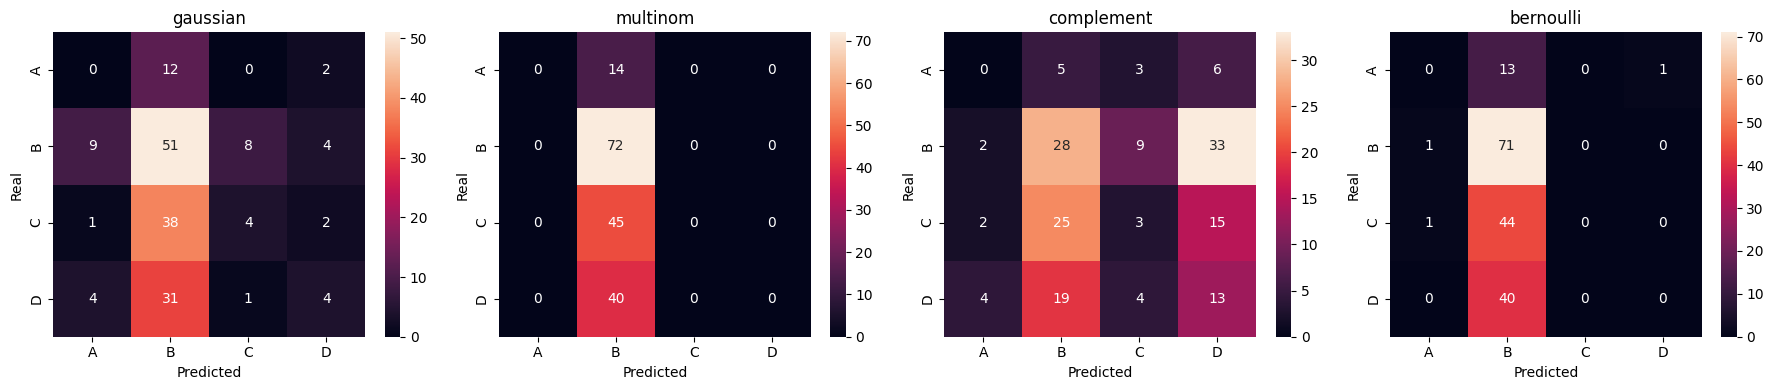

In [ ]:
collinear_cols = get_collinear_features(df_train.drop(columns=["RATE"]), 0.5)
X_train_nonc = X_train.drop(columns=collinear_cols)
X_test_nonc  = X_test.drop(columns=collinear_cols)

res = naive_bayes_fits(X_train_nonc, y_train, X_test_nonc, y_test)

In [ ]:
X_selected

array([[0.75873139, 0.5       , 0.52911516, 0.00175391],
       [0.69070496, 0.75      , 0.56616208, 0.01649424],
       [0.68250483, 0.25      , 0.56259217, 0.06736506],
       ...,
       [0.21382699, 0.        , 0.56718671, 0.03046035],
       [0.86394714, 0.75      , 0.56686977, 0.02031776],
       [0.59444006, 0.5       , 0.54371604, 0.00176894]])

X2 | X1 | 0.95
X3 | X1 | 0.98
X3 | X2 | 0.97
X4 | X1 | 0.93
X4 | X2 | 0.89
X4 | X3 | 0.94
X5 | X1 | 0.96
X5 | X2 | 0.89
X5 | X3 | 0.93
X5 | X4 | 0.9
X6 | X1 | 0.95
X6 | X2 | 0.95
X6 | X3 | 0.96
X6 | X4 | 0.94
X6 | X5 | 0.91
X7 | X1 | 0.97
X7 | X2 | 0.93
X7 | X3 | 0.94
X7 | X4 | 0.85
X7 | X5 | 0.93
X7 | X6 | 0.89
X10 | X1 | 0.89
X10 | X2 | 0.88
X10 | X3 | 0.91
X10 | X4 | 0.92
X10 | X5 | 0.86
X10 | X6 | 0.95
X10 | X7 | 0.82
X10 | X8 | 0.75
X11 | X2 | 0.77
X11 | X3 | 0.77
X11 | X4 | 0.84
X11 | X6 | 0.87
X11 | X10 | 0.9
X17 | X16 | 0.75
X18 | X16 | 0.92
X22 | X15 | 0.8
X32 | X14 | 0.84
X32 | X28 | 0.78
X33 | X32 | 0.81
X35 | X34 | 0.88
X37 | X32 | 0.81
Correlated Columns are: ['X10', 'X11', 'X17', 'X18', 'X2', 'X22', 'X3', 'X32', 'X33', 'X35', 'X37', 'X4', 'X5', 'X6', 'X7']
Variant       F1 Score    Train Acc    Test Acc
----------  ----------  -----------  ----------
gaussian        0.2033      40.2349     39.1813
multinom        0.1481      42.4376     42.1053
complement      0.2437     

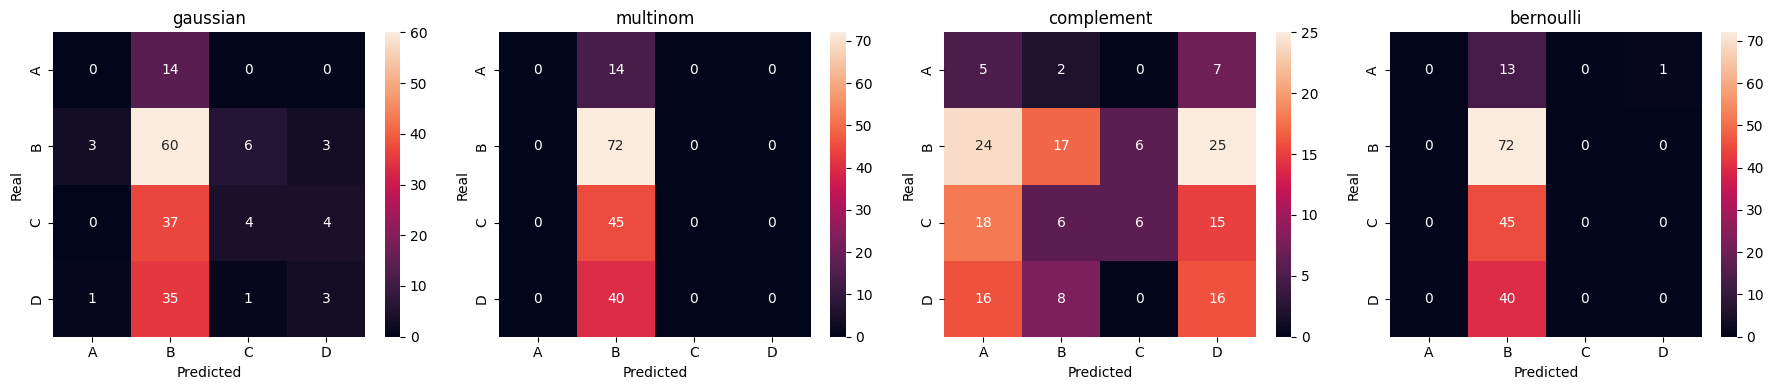

In [ ]:
collinear_cols = get_collinear_features(df_train.drop(columns=["RATE"]), 0.75)
df_train_nonc = df_train.drop(columns=collinear_cols)

fs = SelectPercentile(score_func=f_classif, percentile=25)
X_selected = fs.fit_transform(df_train_nonc.drop(columns=["RATE"]), df_train["RATE"])
X_train, X_test, y_train, y_test = train_test_split(X_selected, 
                                                    df_train["RATE"], stratify=df_train["RATE"], 
                                                    test_size=0.2, 
                                                    random_state=16)
res = naive_bayes_fits(X_train, y_train, X_test, y_test)

### PCA

With 7 components the PCA retains 80.1053% of the original variance.
Variant       F1 Score    Train Acc    Test Acc
----------  ----------  -----------  ----------
gaussian        0.1911      42.1439     41.5205
multinom        0.1481      42.4376     42.1053
complement      0.2648      28.9280     29.8246
bernoulli       0.1467      43.0250     41.5205


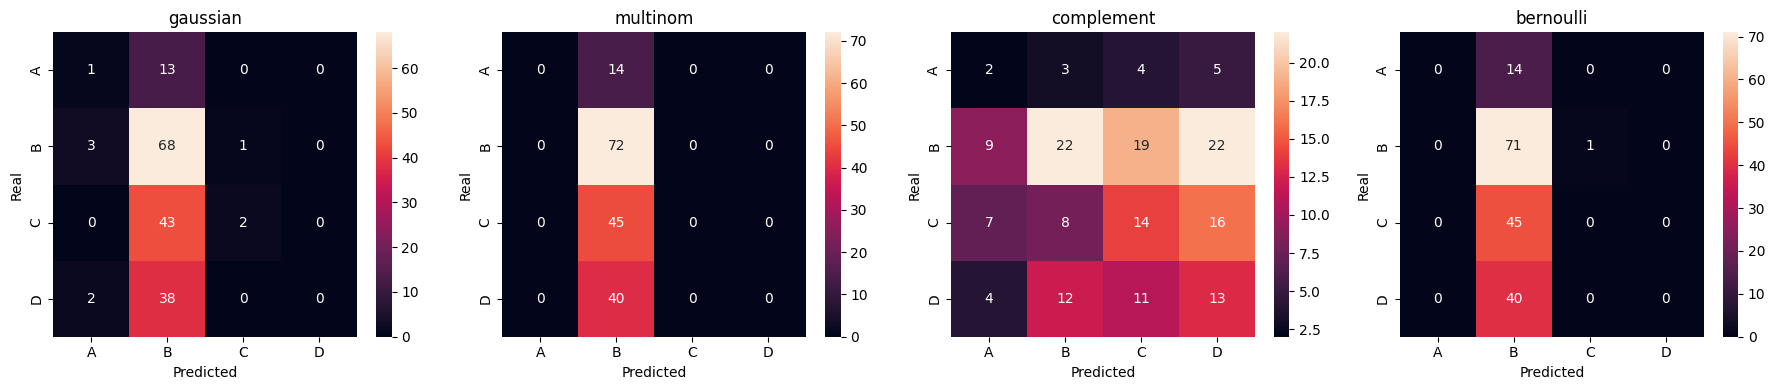

In [ ]:
explained_variance_ratio = 0
i = 0
while(explained_variance_ratio < 0.8):
    i += 1
    pca = PCA(n_components=i)
    pca.fit(df_train.drop(columns=["RATE"]))
    explained_variance_ratio = np.sum(pca.explained_variance_ratio_)

print("With {} components the PCA retains {:.4f}% of the original variance.".format(i, (explained_variance_ratio*100)))

X_train, X_test, y_train, y_test = train_test_split(pca.transform(df_train.drop(columns=["RATE"])), 
                                                    df_train["RATE"], stratify=df_train["RATE"], 
                                                    test_size=0.2, 
                                                    random_state=16)

pca_minmax = MinMaxScaler(feature_range=(0,1))
pca_minmax.fit(X_train)
X_train_pca = pca_minmax.transform(X_train)
X_test_pca = pca_minmax.transform(X_test)

res = naive_bayes_fits(X_train_pca, y_train, X_test_pca, y_test)

## Datos Remuestrados

### Undersampling

In [ ]:
df_under_x, df_under_y = NearMiss().fit_resample(df_credit_x, df_credit_y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_under_x, 
                                                    df_under_y, stratify=df_under_y, 
                                                    test_size=0.2, 
                                                    random_state=16)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

minmax = MinMaxScaler()
minmax.fit(X_train)

X_train = minmax.transform(X_train)
X_test = minmax.transform(X_test)

Variant       F1 Score    Train Acc    Test Acc
----------  ----------  -----------  ----------
gaussian        0.2673      43.7788     27.2727
multinom        0.1730      36.8664     20.0000
complement      0.2337      38.2488     25.4545
bernoulli       0.2284      39.6313     23.6364


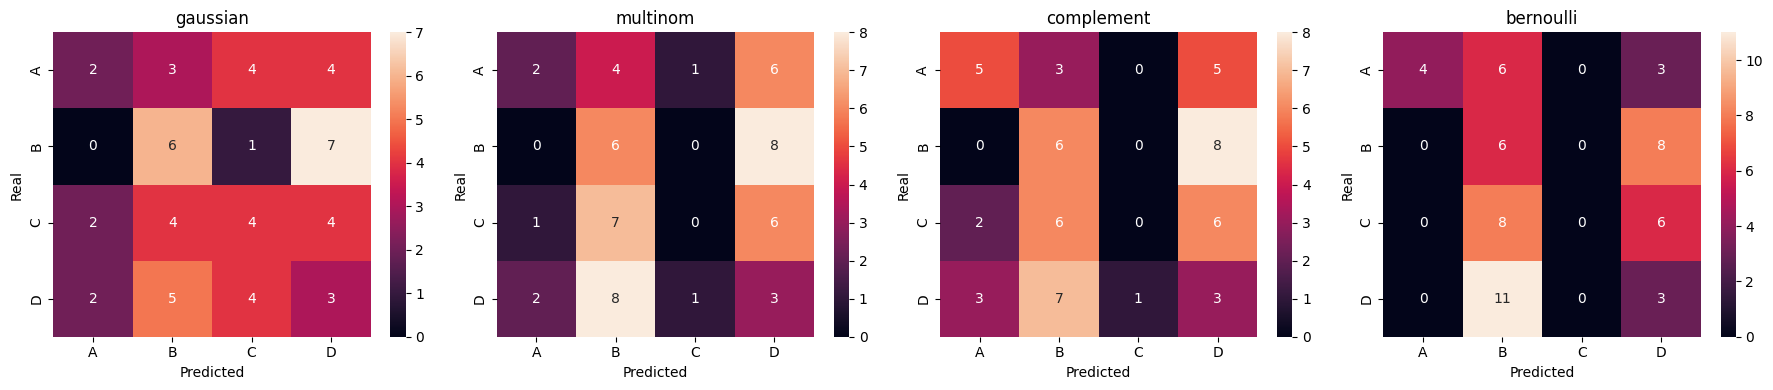

In [ ]:
res_og = naive_bayes_fits(X_train, y_train, X_test, y_test)

(272, 10)
Variant       F1 Score    Train Acc    Test Acc
----------  ----------  -----------  ----------
gaussian        0.2089      33.6406     23.6364
multinom        0.1999      30.4147     21.8182
complement      0.2261      30.8756     25.4545
bernoulli       0.1014      27.1889     25.4545


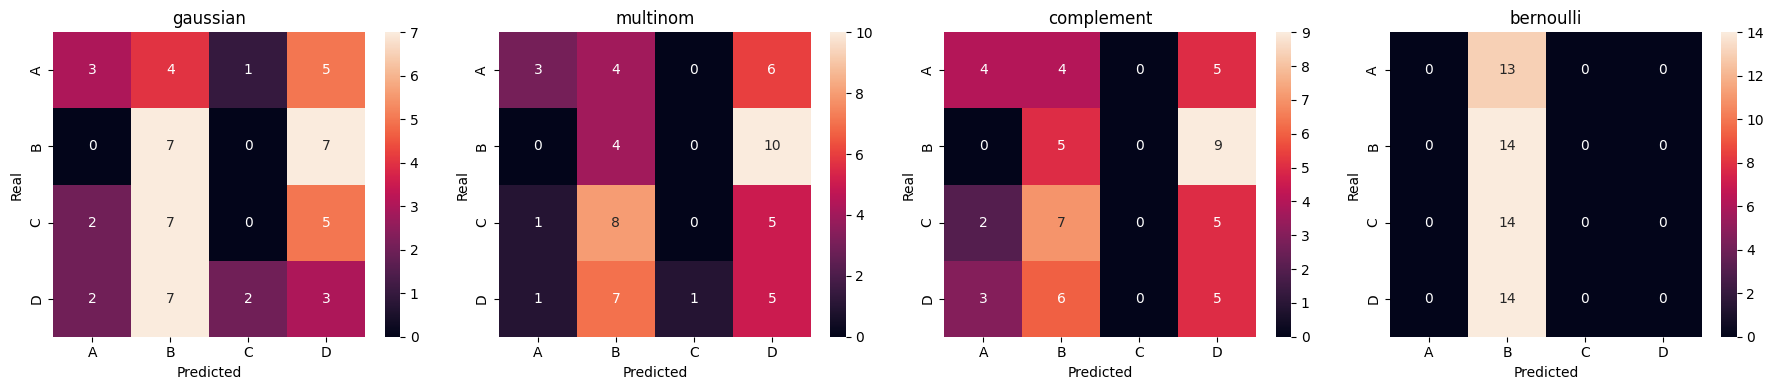

In [ ]:
fs = SelectPercentile(score_func=f_classif, percentile=25)
X_selected = fs.fit_transform(df_under_x, df_under_y)
print(X_selected.shape)

X_train, X_test, y_train, y_test = train_test_split(X_selected, 
                                                    df_under_y, stratify=df_under_y, 
                                                    test_size=0.2, 
                                                    random_state=16)
res = naive_bayes_fits(X_train, y_train, X_test, y_test)

### Oversampling

In [ ]:
# Resample the data
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(df_credit_x, df_credit_y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_res, 
                                                    y_res, stratify=y_res, 
                                                    test_size=0.2, 
                                                    random_state=16)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

minmax = MinMaxScaler()
minmax.fit(X_train)

X_train = minmax.transform(X_train)
X_test = minmax.transform(X_test)

Variant       F1 Score    Train Acc    Test Acc
----------  ----------  -----------  ----------
gaussian        0.1648      27.6190     23.8754
multinom        0.1892      26.4069     24.2215
complement      0.1935      26.2338     24.5675
bernoulli       0.1572      29.3506     27.3356


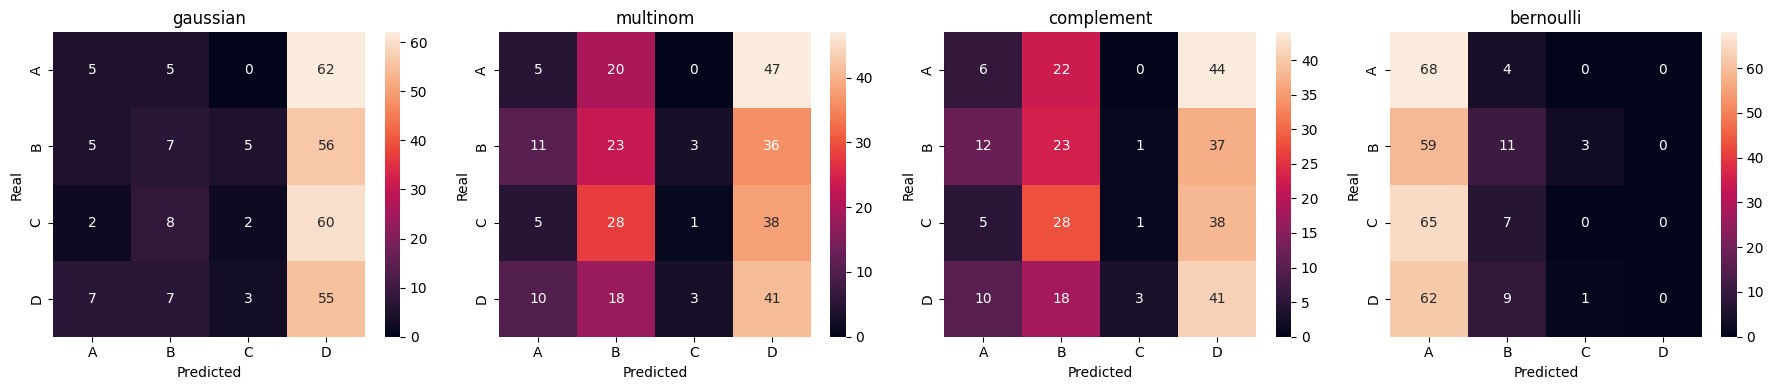

In [ ]:
res_og = naive_bayes_fits(X_train, y_train, X_test, y_test)

(1444, 10)
Variant       F1 Score    Train Acc    Test Acc
----------  ----------  -----------  ----------
gaussian        0.2009      28.2251     28.0277
multinom        0.2922      30.2165     32.8720
complement      0.2704      30.2165     31.1419
bernoulli       0.1195      26.1472     25.6055


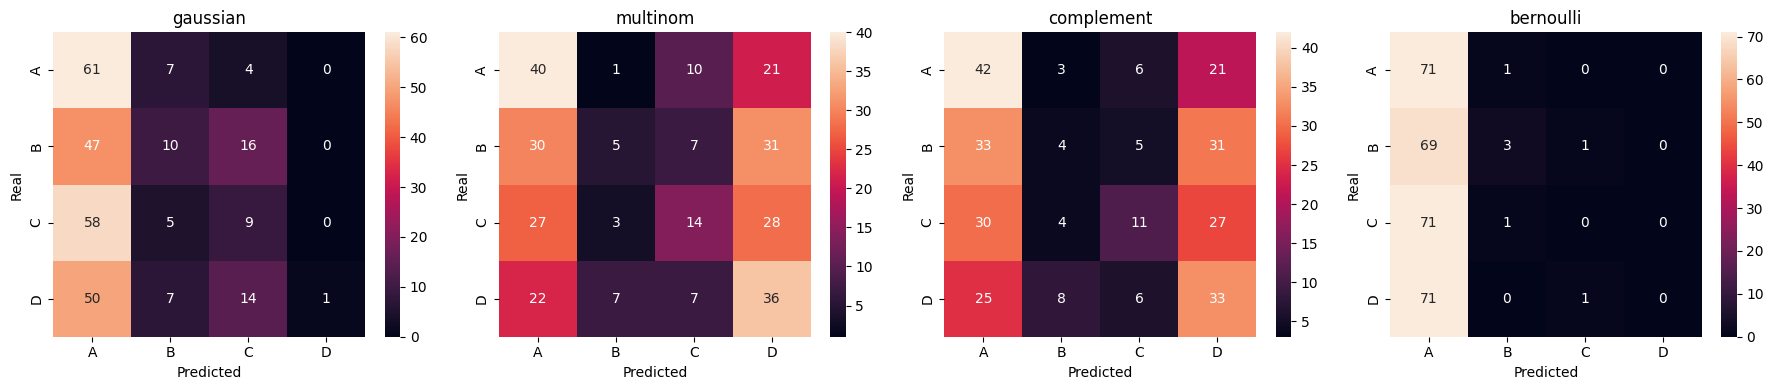

In [ ]:
fs = SelectPercentile(score_func=f_classif, percentile=25)
X_selected = fs.fit_transform(X_res, y_res)
print(X_selected.shape)

X_train, X_test, y_train, y_test = train_test_split(X_selected, 
                                                    y_res, stratify=y_res, 
                                                    test_size=0.2, 
                                                    random_state=16)
res = naive_bayes_fits(X_train, y_train, X_test, y_test)

With 8 components the PCA retains 99.0094% of the original variance.
Variant       F1 Score    Train Acc    Test Acc
----------  ----------  -----------  ----------
gaussian        0.3126      34.1991     33.9100
multinom        0.3496      31.6883     36.6782
complement      0.3596      31.6883     37.3702
bernoulli       0.0997      25.7143     24.9135


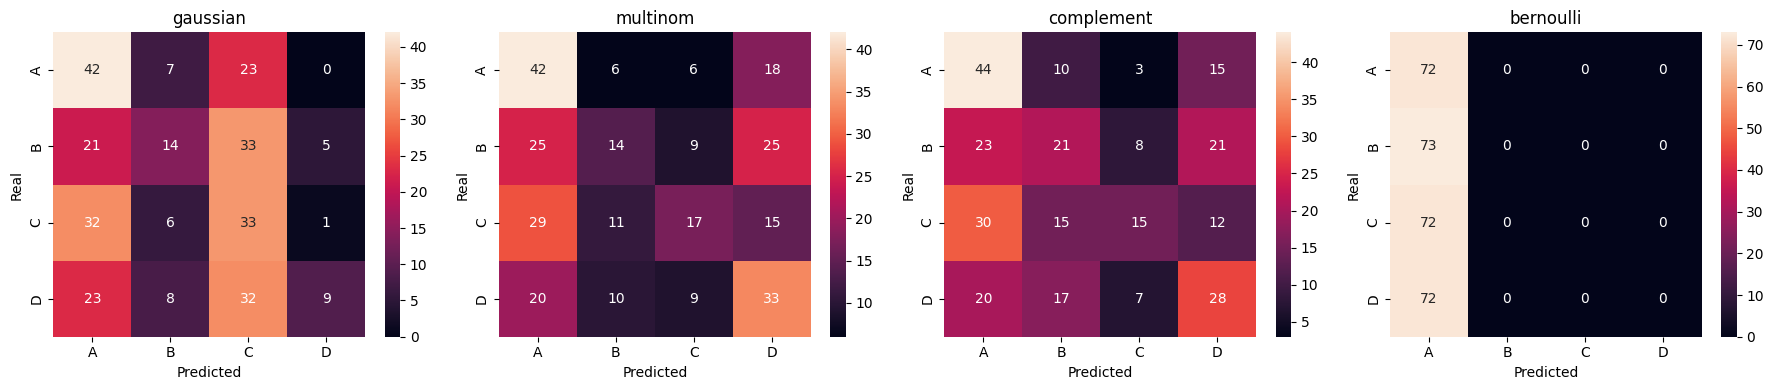

In [ ]:
explained_variance_ratio = 0
i = 0
while(explained_variance_ratio < 0.99):
    i += 1
    pca = PCA(n_components=i)
    pca.fit(X_train)
    explained_variance_ratio = np.sum(pca.explained_variance_ratio_)

print("With {} components the PCA retains {:.4f}% of the original variance.".format(i, (explained_variance_ratio*100)))

X_train = pca.fit_transform(X_train)
x_test  = pca.transform(X_test)

pca_minmax = MinMaxScaler(feature_range=(0,1))
pca_minmax.fit(X_train)
X_train_pca = pca_minmax.transform(X_train)
X_test_pca = pca_minmax.transform(x_test)

res = naive_bayes_fits(X_train_pca, y_train, X_test_pca, y_test)

X2 | X1 | 0.97
X3 | X1 | 0.99
X3 | X2 | 0.98
X4 | X1 | 0.95
X4 | X2 | 0.92
X4 | X3 | 0.96
X5 | X1 | 0.97
X5 | X2 | 0.93
X5 | X3 | 0.95
X5 | X4 | 0.93
X6 | X1 | 0.97
X6 | X2 | 0.97
X6 | X3 | 0.98
X6 | X4 | 0.96
X6 | X5 | 0.94
X7 | X1 | 0.98
X7 | X2 | 0.95
X7 | X3 | 0.96
X7 | X4 | 0.88
X7 | X5 | 0.95
X7 | X6 | 0.92
X8 | X1 | 0.72
X8 | X2 | 0.72
X8 | X3 | 0.75
X8 | X4 | 0.75
X8 | X5 | 0.69
X8 | X6 | 0.75
X8 | X7 | 0.64
X10 | X1 | 0.91
X10 | X2 | 0.91
X10 | X3 | 0.92
X10 | X4 | 0.93
X10 | X5 | 0.9
X10 | X6 | 0.95
X10 | X7 | 0.86
X10 | X8 | 0.8
X11 | X1 | 0.79
X11 | X2 | 0.8
X11 | X3 | 0.81
X11 | X4 | 0.86
X11 | X5 | 0.79
X11 | X6 | 0.87
X11 | X7 | 0.71
X11 | X8 | 0.77
X11 | X10 | 0.92
X16 | X15 | 0.58
X17 | X15 | 0.52
X17 | X16 | 0.76
X18 | X15 | 0.61
X18 | X16 | 0.92
X18 | X17 | 0.76
X21 | X15 | 0.67
X21 | X16 | 0.54
X21 | X18 | 0.6
X22 | X15 | 0.82
X22 | X16 | 0.63
X22 | X17 | 0.58
X22 | X18 | 0.69
X22 | X21 | 0.75
X27 | X14 | 0.67
X27 | X25 | 0.72
X28 | X14 | 0.67
X28 | X27 | 0.55
X32 |

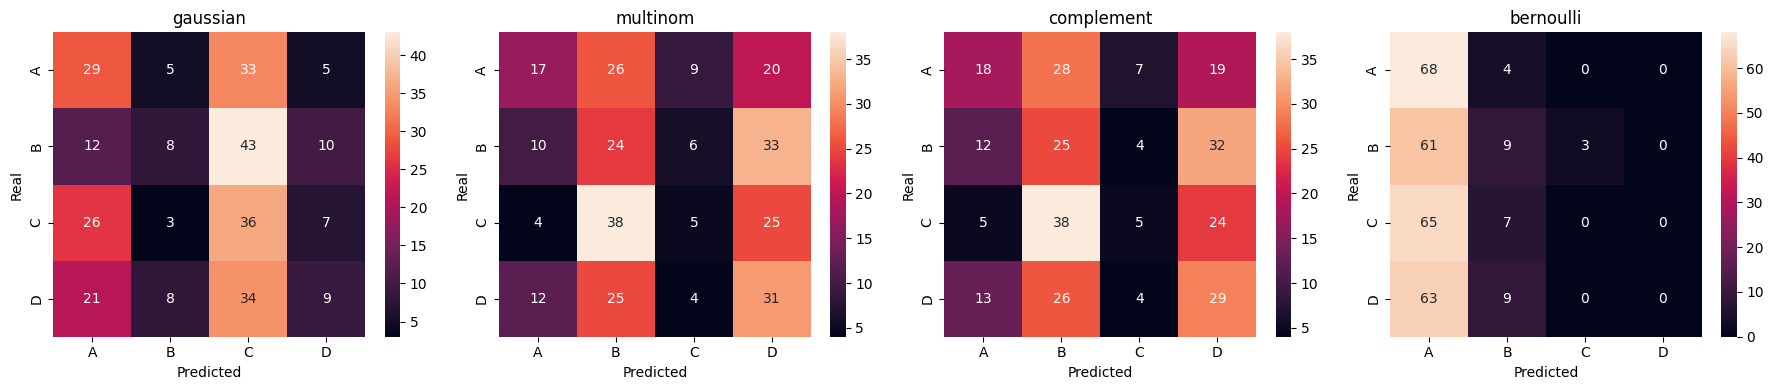

In [ ]:
collinear_cols = get_collinear_features(X_res, 0.5)
X_train_nonc = pd.DataFrame(X_train, columns=X_res.columns).drop(columns=collinear_cols)
X_test_nonc  = pd.DataFrame(X_test, columns=X_res.columns).drop(columns=collinear_cols)

res = naive_bayes_fits(X_train_nonc, y_train, X_test_nonc, y_test)

# Panic Testing...

# DISCRETO

In [387]:
df_credit = pd.read_csv("../data_preprocess/train_preprocess.csv").drop(columns=["ID"])

df_credit_x = df_credit.drop(columns=["RATE"])
df_credit_y = df_credit["RATE"]

df_test = pd.read_csv("../data_preprocess/test_preprocess.csv")
df_test_values = df_test.drop(columns=["ID"])
df_test_IDs = df_test["ID"]

In [388]:
X_train, X_test, y_train, y_test = train_test_split(df_credit_x, 
                                                    df_credit_y,stratify=df_credit_y,
                                                    test_size=0.2, 
                                                    random_state=0)

In [406]:
collinear_cols = get_collinear_features(X_train, 0.5)
X_train = X_train.drop(columns=collinear_cols)
X_test  = X_test.drop(columns=collinear_cols)

AttributeError: 'numpy.ndarray' object has no attribute 'corr'

In [322]:
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [397]:
explained_variance_ratio = 0
i = 0
while(explained_variance_ratio < 0.8):
    i += 1
    pca = PCA(n_components=i)
    pca.fit(X_train)
    explained_variance_ratio = np.sum(pca.explained_variance_ratio_)

print("With {} components the PCA retains {:.4f}% of the original variance.".format(i, (explained_variance_ratio*100)))

X_train = pca.transform(X_train)
X_test  = pca.transform(X_test)

With 12 components the PCA retains 82.0459% of the original variance.


In [374]:
X_train, y_train = NearMiss(version=2).fit_resample(X_train, y_train)

In [409]:
fs = SelectPercentile(score_func=f_classif, percentile=25)
X_train = fs.fit_transform(X_train, y_train)
X_test  = fs.transform(X_test)

In [382]:
discretizer = KBinsDiscretizer(n_bins=30, encode="onehot-dense", strategy="kmeans")

In [383]:
X_train = discretizer.fit_transform(X_train)
X_test  = discretizer.transform(X_test)

/media/valentino/Irithyll1/repos/ClubFansIris/env/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/media/valentino/Irithyll1/repos/ClubFansIris/env/lib/python3.10/site-packages/sklearn/base.py:1152: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/media/valentino/Irithyll1/repos/ClubFansIris/env/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 23 are removed. Consider decreasing the number of bins.
  warnings.warn(
/media/valentino/Irithyll1/repos/ClubFansIris/env/lib/python3.10/site-packages/sklearn/base.py:1152: Convergen

In [384]:
discretizer.get_feature_names_out()

array(['X1_0.0', 'X1_1.0', 'X1_2.0', 'X1_3.0', 'X1_4.0', 'X1_5.0',
       'X1_6.0', 'X1_7.0', 'X1_8.0', 'X1_9.0', 'X1_10.0', 'X1_11.0',
       'X1_12.0', 'X1_13.0', 'X1_14.0', 'X2_0.0', 'X2_1.0', 'X2_2.0',
       'X2_3.0', 'X2_4.0', 'X2_5.0', 'X2_6.0', 'X2_7.0', 'X2_8.0',
       'X2_9.0', 'X2_10.0', 'X2_11.0', 'X2_12.0', 'X2_13.0', 'X2_14.0',
       'X3_0.0', 'X3_1.0', 'X3_2.0', 'X3_3.0', 'X3_4.0', 'X3_5.0',
       'X3_6.0', 'X3_7.0', 'X3_8.0', 'X3_9.0', 'X3_10.0', 'X3_11.0',
       'X3_12.0', 'X3_13.0', 'X3_14.0', 'X4_0.0', 'X4_1.0', 'X4_2.0',
       'X4_3.0', 'X4_4.0', 'X4_5.0', 'X4_6.0', 'X4_7.0', 'X4_8.0',
       'X4_9.0', 'X4_10.0', 'X4_11.0', 'X4_12.0', 'X4_13.0', 'X4_14.0',
       'X5_0.0', 'X5_1.0', 'X5_2.0', 'X5_3.0', 'X5_4.0', 'X5_5.0',
       'X5_6.0', 'X5_7.0', 'X5_8.0', 'X5_9.0', 'X5_10.0', 'X5_11.0',
       'X5_12.0', 'X5_13.0', 'X5_14.0', 'X6_0.0', 'X6_1.0', 'X6_2.0',
       'X6_3.0', 'X6_4.0', 'X6_5.0', 'X6_6.0', 'X6_7.0', 'X6_8.0',
       'X6_9.0', 'X6_10.0', 'X6_11.0'

In [385]:
results = {
    # "gaussian" : {"model" : GaussianNB()},
    # "multinom" : {"model" : MultinomialNB(force_alpha=True)},
    # "complement" : {"model" : ComplementNB(force_alpha=True)},
    # "bernoulli" : {"model" : BernoulliNB(force_alpha=True)},
    "categorical_1" : {"model" : CategoricalNB(force_alpha=True)},
    # "categorical_2" : {"model" : CategoricalNB(force_alpha=True, fit_prior=False)},
    # "categorical_4" : {"model" : CategoricalNB(force_alpha=True, alpha=0.75)}
}

Variant          F1 Score    Train Acc    Test Acc
-------------  ----------  -----------  ----------
categorical_1      0.2307      60.6461     26.3158


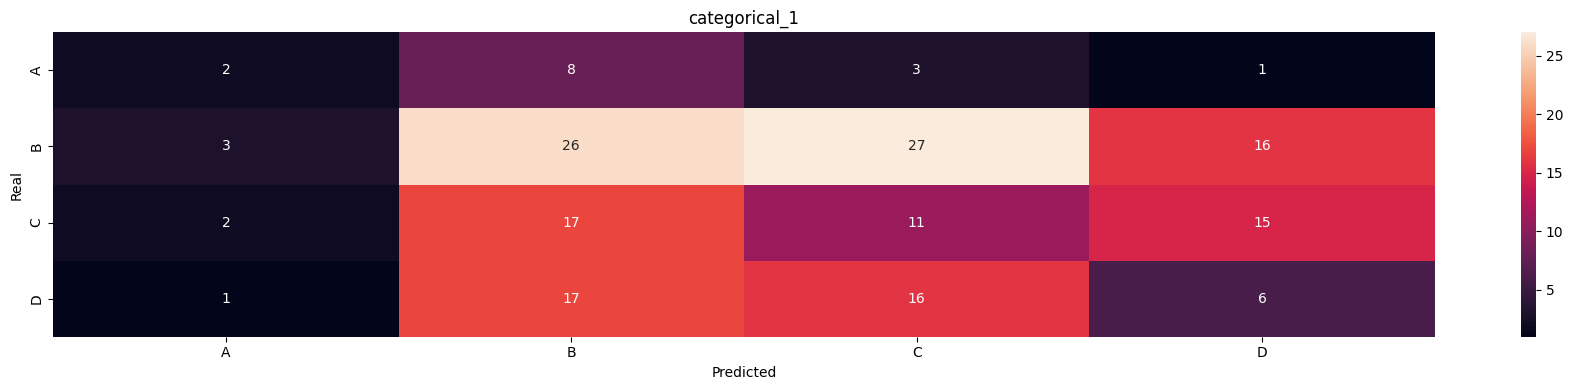

In [386]:
out = naive_bayes_fits(results, X_train, y_train, X_test, y_test)